<a href="https://colab.research.google.com/github/semihberat/Custom-Deep-Learning-Model/blob/main/NeuralNetworkWithOnlyNumpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, f1_score

In [2]:
class NeuralNetwork:
    def __init__(self):
        # Initialize model parameters
        self.layers = []  # List to store layers
        self.params = {}  # Dictionary to store weights (W) and biases (b)
        self.grads = {}  # Dictionary to store gradients of weights and biases
        self.history = {"accuracy": [], "cost": []}  # History to store accuracy and cost for each epoch

    def add(self, n, activation, dropout=0.0):
        """
        Add a layer to the neural network.
        n: Number of neurons in the layer
        activation: Activation function ('relu', 'sigmoid', 'tanh', 'softmax')
        dropout: Dropout rate (default is 0.0, can be set to 0.5 or other values)
        """
        # Define activation functions and their derivatives
        if activation == "relu":
            act = lambda x: np.maximum(0, x)
            der = lambda x: np.where(x > 0, 1, 0)
        elif activation == "sigmoid":
            act = lambda x: 1 / (1 + np.exp(-x))
            der = lambda x: act(x) * (1 - act(x))
        elif activation == "tanh":
            act = lambda x: np.tanh(x)
            der = lambda x: 1 - np.tanh(x) ** 2
        elif activation == "softmax":
            act = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0, keepdims=True)
            der = lambda x: act(x) * (1 - act(x))  # This is simplified for backpropagation purposes
        else:
            raise ValueError("Invalid activation function")

        # Add the layer to the network
        self.layers.append({"n": n, "activation": act, "derivation": der, "dropout": dropout})

    def initialize_params(self, input_dim):
        """
        Initialize the weights (W) and biases (b) of the model.
        input_dim: The number of features in the input data (number of rows in X)
        """
        for l in range(len(self.layers)):
            if l == 0:
                self.params["W" + str(l + 1)] = np.random.randn(self.layers[l]["n"], input_dim) * 0.01
            else:
                self.params["W" + str(l + 1)] = np.random.randn(self.layers[l]["n"], self.layers[l - 1]["n"]) * 0.01
            self.params["b" + str(l + 1)] = np.zeros((self.layers[l]["n"], 1))

    def forward(self, X):
        """
        Perform forward propagation (feedforward) to calculate activations.
        X: Input data
        """
        self.params["A0"] = X  # Set the input layer (A0)

        for l in range(len(self.layers)):
            # Calculate linear combination Z = W.A + b
            Z = np.dot(self.params["W" + str(l + 1)], self.params["A" + str(l)]) + self.params["b" + str(l + 1)]
            # Apply activation function
            A = self.layers[l]["activation"](Z)
            # Apply dropout (layer-specific)
            D = np.random.rand(A.shape[0], A.shape[1]) < (1 - self.layers[l]["dropout"])
            A = A * D / (1 - self.layers[l]["dropout"])  # Normalize dropout
            # Store the intermediate results
            self.params["Z" + str(l + 1)] = Z
            self.params["A" + str(l + 1)] = A
            self.params["D" + str(l + 1)] = D  # Save dropout mask

    def backward(self, X, Y):
        """
        Perform backward propagation to calculate gradients.
        X: Input data
        Y: True labels
        """
        m = X.shape[1]  # Number of examples in the dataset

        # Backpropagate from the output layer to the input layer
        for l in reversed(range(len(self.layers))):
            derivation = self.layers[l]["derivation"]
            if l == len(self.layers) - 1:
                # For the output layer (softmax or sigmoid)
                dA = self.params["A" + str(l + 1)] - Y  # Softmax gradient (cross-entropy)
            else:
                # For other layers, use the chain rule
                dA = np.dot(self.params["W" + str(l + 2)].T, self.grads["dZ" + str(l + 2)])

            # Compute gradients for the current layer
            self.grads["dZ" + str(l + 1)] = dA * derivation(self.params["Z" + str(l + 1)])
            self.grads["dW" + str(l + 1)] = 1 / m * np.dot(self.grads["dZ" + str(l + 1)], self.params["A" + str(l)].T)
            self.grads["db" + str(l + 1)] = 1 / m * np.sum(self.grads["dZ" + str(l + 1)], axis=1, keepdims=True)

            # Apply the gradient of the dropout during backpropagation
            self.grads["dA" + str(l)] = self.grads["dZ" + str(l + 1)] * self.params["D" + str(l + 1)] / (1 - self.layers[l]["dropout"])

    def update_params(self, alpha):
        """
        Update the weights and biases using gradient descent.
        alpha: Learning rate
        """
        for l in range(len(self.layers)):
            self.params["W" + str(l + 1)] -= alpha * self.grads["dW" + str(l + 1)]
            self.params["b" + str(l + 1)] -= alpha * self.grads["db" + str(l + 1)]

    def calculate_cost(self, Y, Y_pred):
        """
        Compute the cost function (Binary Cross-Entropy Loss or Categorical Cross-Entropy Loss).
        Y: True labels
        Y_pred: Predicted labels
        """
        m = Y.shape[1]
        if Y_pred.shape[0] == 1:  # If it's binary classification (sigmoid output)
            cost = (-1 / m) * np.sum(Y * np.log(Y_pred) + (1 - Y) * np.log(1 - Y_pred))
        else:  # Multi-class classification (softmax output)
            cost = (-1 / m) * np.sum(Y * np.log(Y_pred))  # Categorical cross-entropy

        self.history["cost"].append(cost)  # Store the cost history
        return cost

    def accuracy(self, Y, Y_pred):
        """
        Compute the accuracy of the model.
        Y: True labels
        Y_pred: Predicted labels
        """
        acc = accuracy_score(Y.flatten(), (Y_pred > 0.5).astype(int).flatten())  # Use 0.5 threshold for binary classification
        self.history["accuracy"].append(acc)  # Store accuracy history
        return acc

    def fit(self, X, Y, epochs, alpha):
        """
        Train the model using the entire dataset (full-batch gradient descent).
        X: Input data
        Y: True labels
        epochs: Number of training epochs
        alpha: Learning rate
        """
        input_dim = X.shape[0]
        self.initialize_params(input_dim)  # Initialize weights and biases

        for i in range(1, epochs + 1):
            self.forward(X)  # Perform forward propagation
            Y_pred = self.params["A" + str(len(self.layers))]  # Get the predictions
            cost = self.calculate_cost(Y, Y_pred)  # Calculate cost
            accuracy = self.accuracy(Y, Y_pred)  # Calculate accuracy

            # Print cost and accuracy every 100 epochs
            if i % 100 == 0:
                print(f"Epoch {i}/{epochs}, Cost: {cost:.2f} Accuracy: {accuracy:.2f}")

            self.backward(X, Y)  # Perform backward propagation
            self.update_params(alpha)  # Update weights and biases

    def mini_batch_fit(self, X, Y, epochs, alpha, batch_size):
        """
        Train the model using mini-batch gradient descent.
        X: Input data
        Y: True labels
        epochs: Number of training epochs
        alpha: Learning rate
        batch_size: Size of each mini-batch
        """
        input_dim = X.shape[0]
        self.initialize_params(input_dim)  # Initialize weights and biases

        for i in range(1, epochs + 1):
            for j in range(0, X.shape[1], batch_size):
                # Generate mini-batches
                X_batch = X[:, j:j + batch_size]
                Y_batch = Y[:, j:j + batch_size]

                self.forward(X_batch)  # Perform forward propagation
                self.backward(X_batch, Y_batch)  # Perform backward propagation
                self.update_params(alpha)  # Update weights and biases

            # Calculate cost and accuracy at the end of each epoch
            Y_pred = self.params["A" + str(len(self.layers))]
            cost = self.calculate_cost(Y_batch, Y_pred)
            accuracy = self.accuracy(Y_batch, Y_pred)

            # Print cost and accuracy every 100 epochs
            if i % 100 == 0:
                print(f"Epoch {i}/{epochs}, Cost: {cost:.4f} Accuracy: {accuracy:.4f}")

    def predict(self, X):
        """
        Make predictions on new data.
        X: New input data
        """
        self.forward(X)  # Perform forward propagation
        return self.params["A" + str(len(self.layers))]  # Return predictions from the output layer


In [3]:
# Import necessary libraries
from sklearn.datasets import load_breast_cancer  # For loading the breast cancer dataset
from sklearn.model_selection import train_test_split  # For splitting the dataset into train and test sets
from sklearn.preprocessing import StandardScaler  # For feature scaling

# Load the breast cancer dataset
data = load_breast_cancer()

# Get the feature matrix X (input data) and target vector y (labels)
X, y = data.data, data.target

# Split the data into training and test sets (80% train, 20% test)
# random_state ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling: Standardizing the features to have zero mean and unit variance
# Fit the scaler on the training data, and transform both the training and test data
scaler = StandardScaler()

# Fit the scaler on the training set and apply transformation to X_train
X_train = scaler.fit_transform(X_train)

# Apply the same transformation to X_test using the already fitted scaler
X_test = scaler.transform(X_test)

# Now X_train and X_test are scaled and ready for training a model

In [4]:
# Access the target labels and feature names from the breast cancer dataset
targets, features = data.target_names, data.feature_names

# Print out the target labels (i.e., the class labels)
print(f"Targets: {targets}")

# Print out the feature names (i.e., the columns of the feature matrix)
print(f"Features: {features}")

Targets: ['malignant' 'benign']
Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [5]:
# Reshaping the training data and target labels
# X_train.shape[0] is the number of training examples (rows), and we reshape X_train
# to have each feature as a column, hence we transpose the data.
X_train = X_train.reshape(X_train.shape[0], -1).T  # Reshape X_train to (num_features, num_samples)

# Reshaping y_train so that it becomes a column vector with one target value per sample
y_train = y_train.reshape(y_train.shape[0], -1).T  # Reshape y_train to (1, num_samples)

# Print the shapes of X_train and y_train to verify the reshaping
print("Shape of X_train:",X_train.shape)  # Should print (num_features, num_samples)
print("SHape of y_train:",y_train.shape)  # Should print (1, num_samples)

Shape of X_train: (30, 455)
SHape of y_train: (1, 455)


In [6]:
# Reshaping the test data and target labels
# X_test.shape[0] is the number of test samples (rows), and we reshape X_test
# to have each feature as a column, hence we transpose the data.
X_test = X_test.reshape(X_test.shape[0], -1).T  # Reshape X_test to (num_features, num_samples)

# Reshaping y_test so that it becomes a column vector with one target value per sample
y_test = y_test.reshape(y_test.shape[0], -1).T  # Reshape y_test to (1, num_samples)

# Print the shapes of X_test and y_test to verify the reshaping
print(X_test.shape)  # Should print (num_features, num_samples)
print(y_test.shape)  # Should print (1, num_samples)

(30, 114)
(1, 114)


In [7]:
import pandas as pd
import numpy as np

# Assuming features contain the 30 feature names
# Check if features contains 30 elements
print(f"Number of features: {len(features)}")

# Convert y_train to human-readable form
y_target = np.where(y_train == 0, "Benign", "Malignant")
y_target = y_target.reshape(-1, 1)  # Ensure it's a column vector

# Ensure the shape of X_train is (455, 30) and features is an array of size 30
print("X_train shape:", X_train.shape)
print("features length:", len(features))

# Create the DataFrame for the features
df_X = pd.DataFrame(X_train.T, columns=features)

# Create the DataFrame for the target labels
df_y = pd.DataFrame(y_target, columns=["target"])

# Concatenate features and target data along the columns
df = pd.concat([df_X, df_y], axis=1)

# Display the first few rows of the DataFrame
print(df.head())


Number of features: 30
X_train shape: (30, 455)
features length: 30
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0    -1.440753     -0.435319       -1.362085  -1.139118         0.780573   
1     1.974096      1.733026        2.091672   1.851973         1.319843   
2    -1.399982     -1.249622       -1.345209  -1.109785        -1.332645   
3    -0.981797      1.416222       -0.982587  -0.866944         0.059390   
4    -1.117700     -1.010259       -1.125002  -0.965942         1.269511   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0          0.718921        2.823135            -0.119150       1.092662   
1          3.426275        2.013112             2.665032       2.127004   
2         -0.307355       -0.365558            -0.696502       1.930333   
3         -0.596788       -0.820203            -0.845115       0.313264   
4         -0.439002       -0.983341            -0.930600       3.394436   

   mean fractal dimensio

<ipython-input-8-3fbe7f43756a>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="target", data=df, palette="viridis")  # Using a more distinct color palette


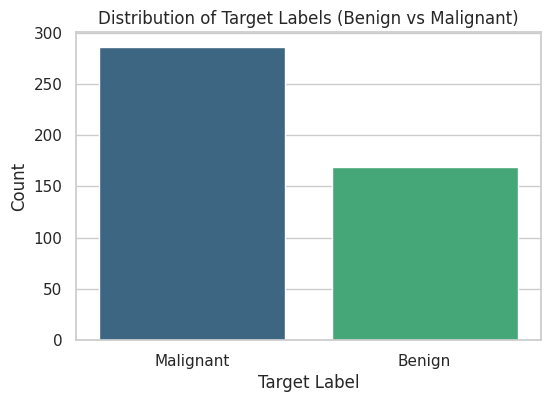

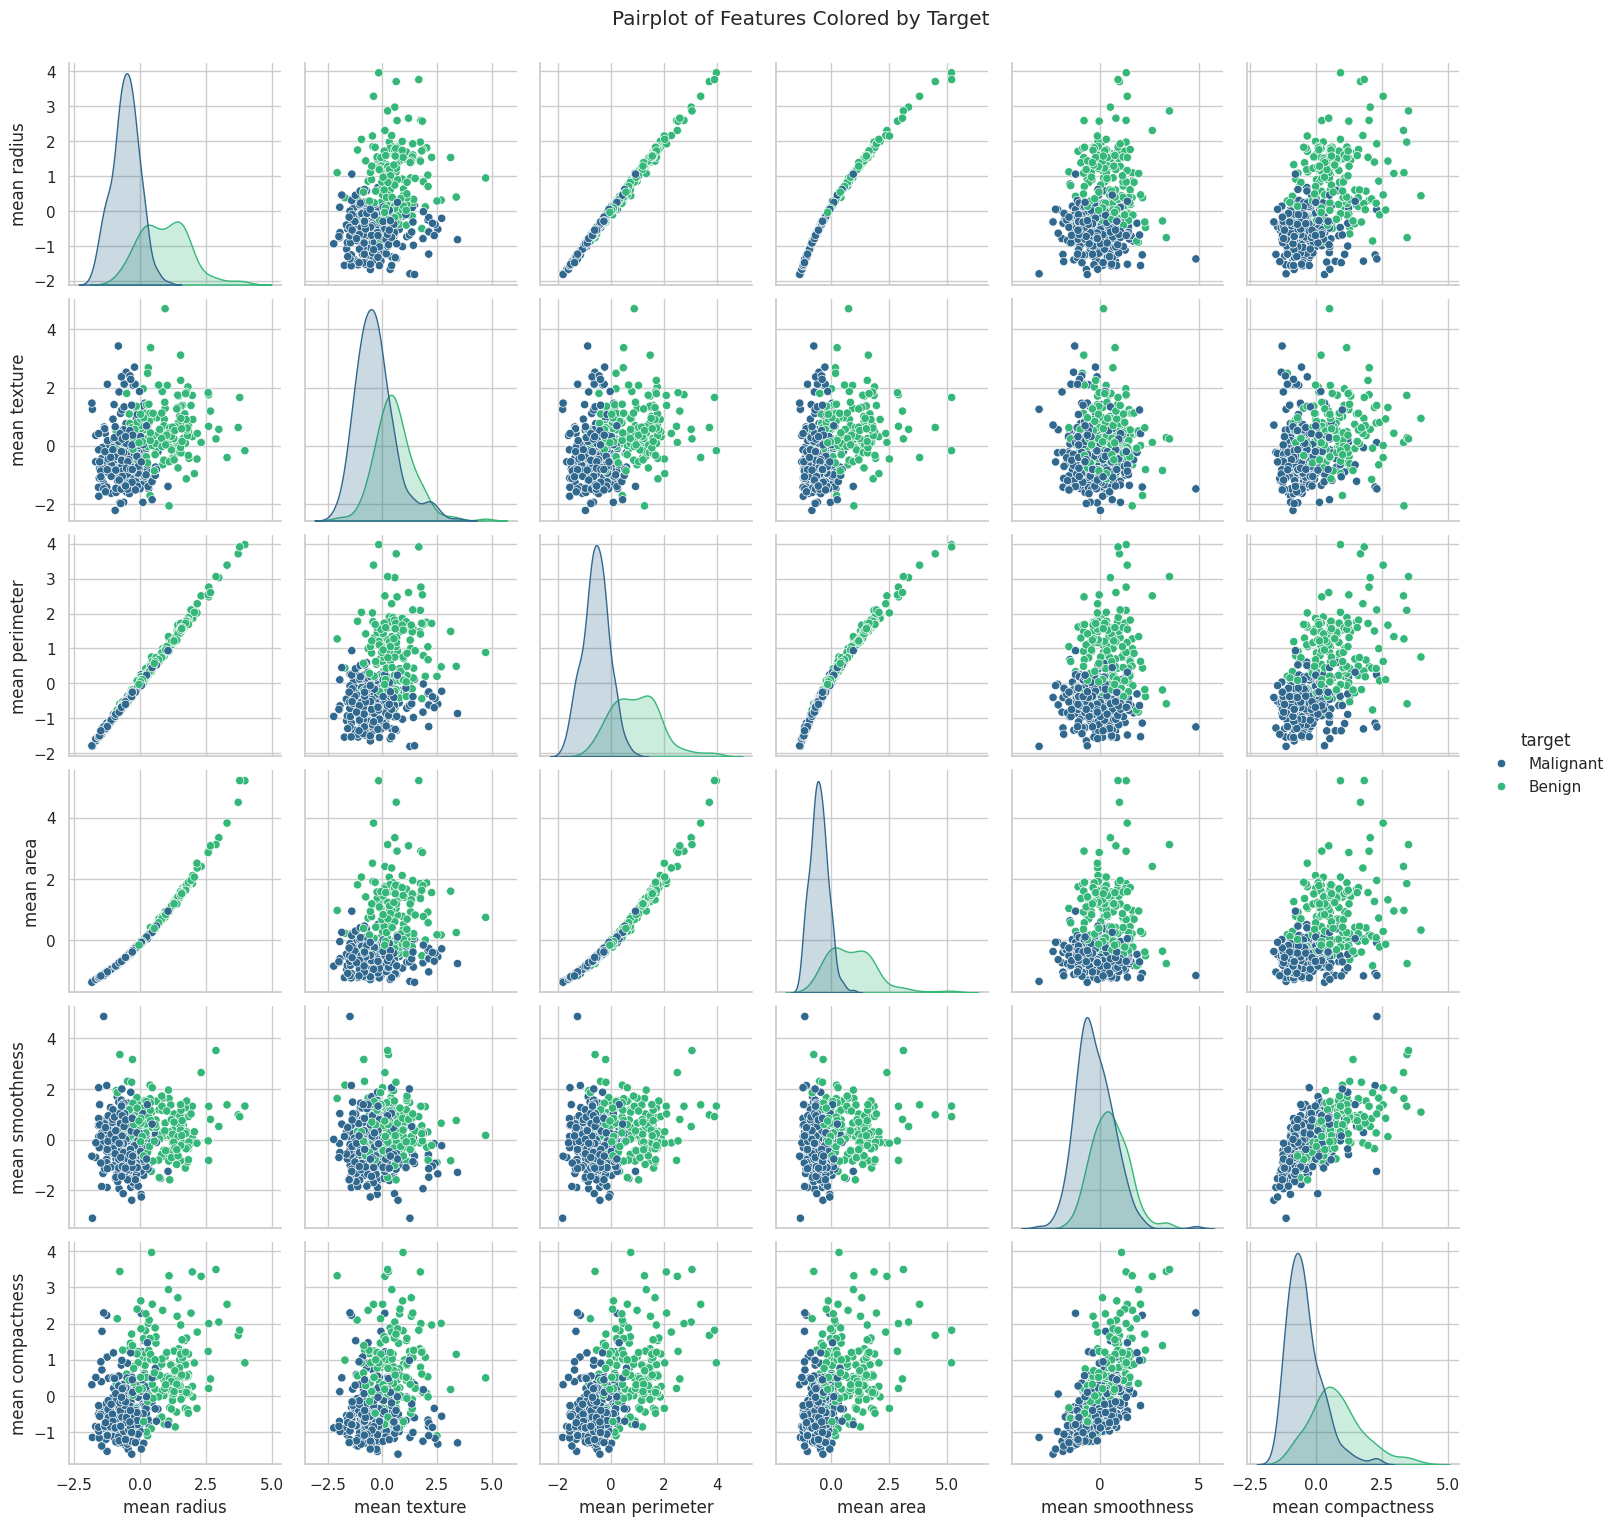

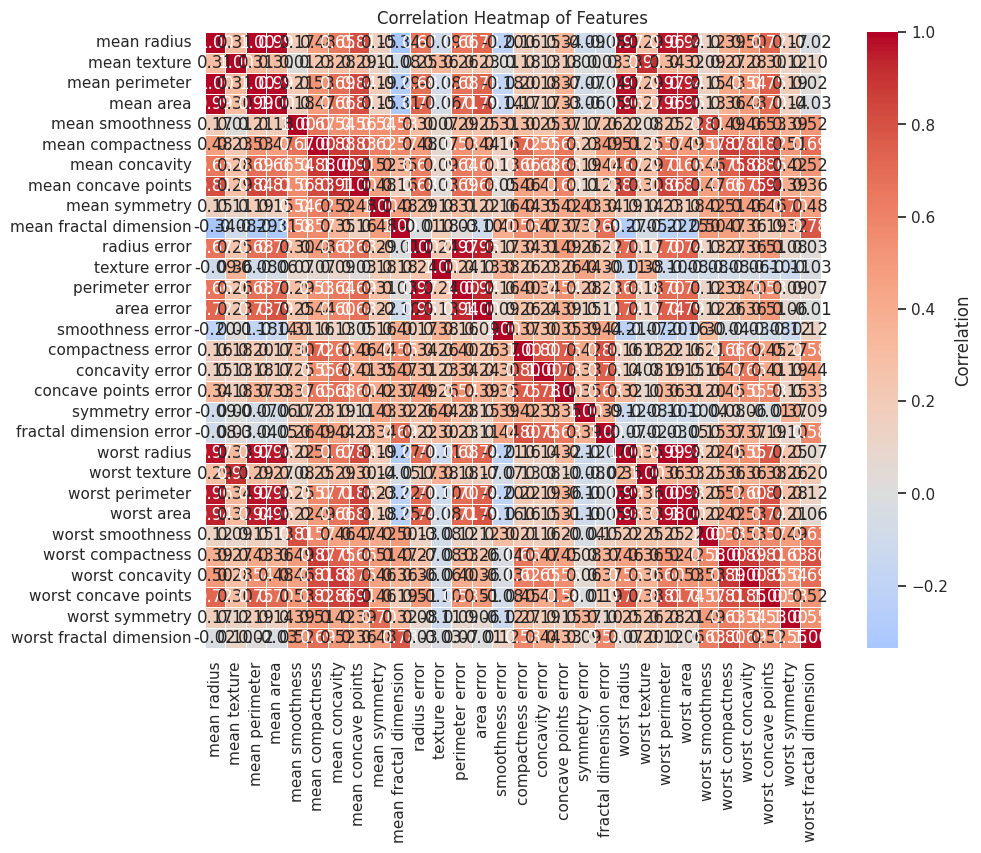

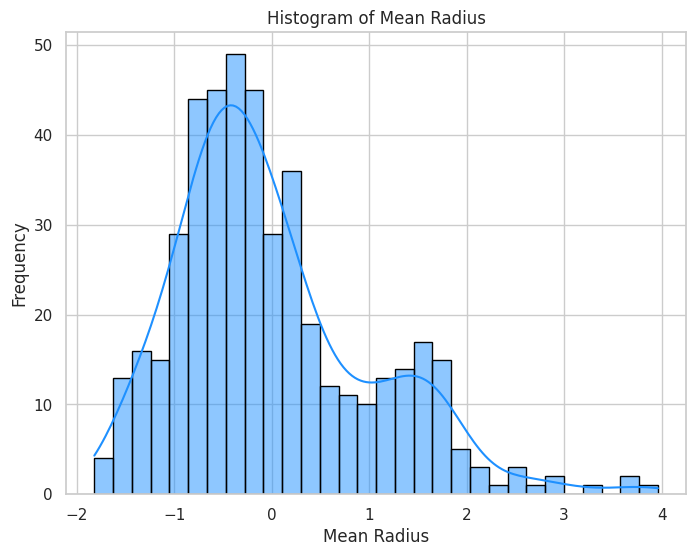

<ipython-input-8-3fbe7f43756a>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="target", y="mean radius", data=df, palette="Set2", width=0.5, fliersize=8)


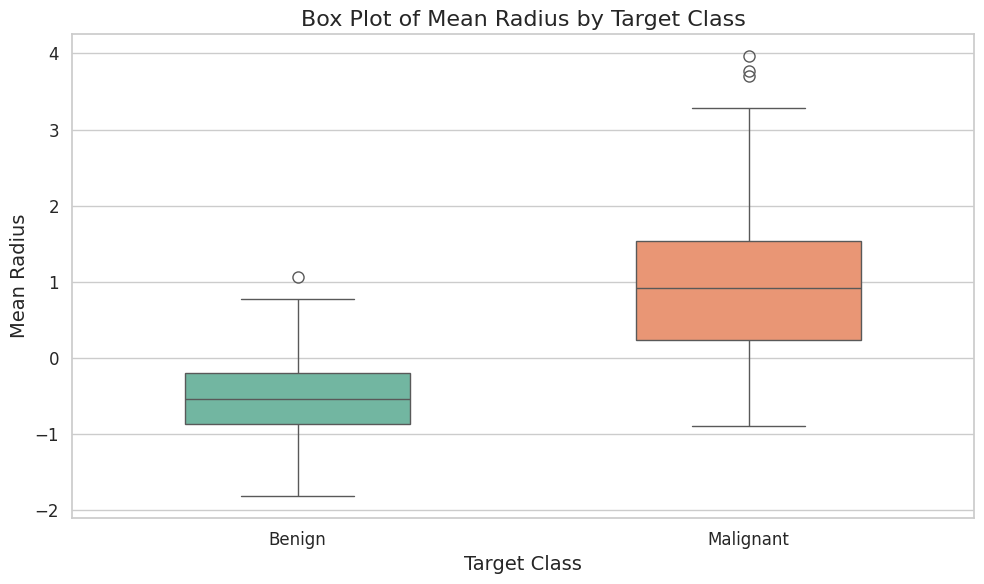

<ipython-input-8-3fbe7f43756a>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="target", y="mean area", data=df, palette="Set2")


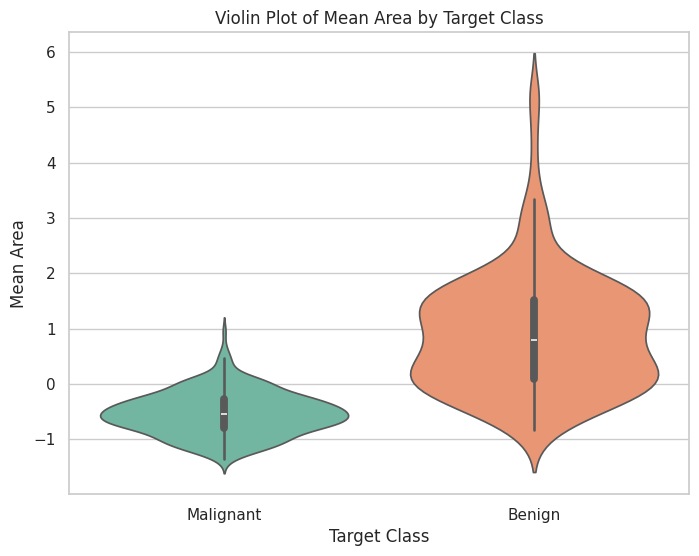

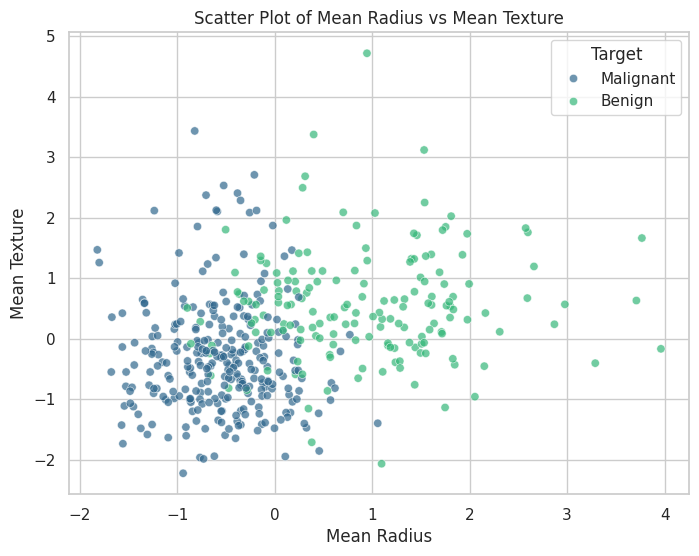

In [8]:
# Assuming df is the DataFrame with features and target, and features is already defined
# Set Seaborn style for a clean and consistent look
sns.set(style="whitegrid")

# 1. Distribution of Target Labels (Benign vs Malignant)
plt.figure(figsize=(6, 4))
sns.countplot(x="target", data=df, palette="viridis")  # Using a more distinct color palette
plt.title('Distribution of Target Labels (Benign vs Malignant)')
plt.xlabel('Target Label')
plt.ylabel('Count')
plt.show()

# 2. Pairplot of Features Colored by Target
# We'll limit to just a few features for better visibility in pairplot
subset_features = df.columns[:6]  # Limit to first 6 features for simplicity
sns.pairplot(df[subset_features].join(df['target']), hue="target", palette="viridis")
plt.suptitle('Pairplot of Features Colored by Target', y=1.02)
plt.show()

# 3. Correlation Heatmap of the Features
# Correlation of numerical features with a clean color map and better organization
correlation_matrix = df[features].corr()  # Correlation matrix of features
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            cbar_kws={'label': 'Correlation'}, square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

# 4. Histogram of a Feature (e.g., 'mean radius') for distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['mean radius'], kde=True, color='dodgerblue', bins=30, edgecolor='black')
plt.title('Histogram of Mean Radius')
plt.xlabel('Mean Radius')
plt.ylabel('Frequency')
plt.show()

# 5. Box Plot for Feature Comparison by Target Class
plt.figure(figsize=(10, 6))
# Adjusting the box plot to make the boxes more separated and readable
sns.boxplot(x="target", y="mean radius", data=df, palette="Set2", width=0.5, fliersize=8)
# Title and labels with adjusted font size for readability
plt.title('Box Plot of Mean Radius by Target Class', fontsize=16)
plt.xlabel('Target Class', fontsize=14)
plt.ylabel('Mean Radius', fontsize=14)

# Customize ticks to improve spacing and readability
plt.xticks([0, 1], ['Benign', 'Malignant'], fontsize=12)
plt.yticks(fontsize=12)

# Add some padding for better clarity
plt.tight_layout()

# Show the plot
plt.show()

# 6. Violin Plot of Feature Distribution by Target Class (Another feature, e.g., 'mean area')
plt.figure(figsize=(8, 6))
sns.violinplot(x="target", y="mean area", data=df, palette="Set2")
plt.title('Violin Plot of Mean Area by Target Class')
plt.xlabel('Target Class')
plt.ylabel('Mean Area')
plt.show()

# 7. Feature Pair Correlation Plot (using scatterplot)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['mean radius'], y=df['mean texture'], hue=df['target'], palette="viridis", alpha=0.7)
plt.title('Scatter Plot of Mean Radius vs Mean Texture')
plt.xlabel('Mean Radius')
plt.ylabel('Mean Texture')
plt.legend(title='Target', loc='upper right')
plt.show()


In [9]:
nn1 = NeuralNetwork()
nn1.add(64, "tanh")
nn1.add(1, "sigmoid")

nn1.fit(X_train, y_train, epochs=500, alpha=0.01)

Epoch 100/500, Cost: 0.68 Accuracy: 0.67
Epoch 200/500, Cost: 0.67 Accuracy: 0.69
Epoch 300/500, Cost: 0.66 Accuracy: 0.76
Epoch 400/500, Cost: 0.63 Accuracy: 0.85
Epoch 500/500, Cost: 0.59 Accuracy: 0.89


In [10]:
nn2 = NeuralNetwork()
nn2.add(64, "tanh")
nn2.add(1, "sigmoid")

nn2.fit(X_test, y_test, epochs=500, alpha=0.01)

Epoch 100/500, Cost: 0.68 Accuracy: 0.68
Epoch 200/500, Cost: 0.67 Accuracy: 0.76
Epoch 300/500, Cost: 0.65 Accuracy: 0.81
Epoch 400/500, Cost: 0.62 Accuracy: 0.86
Epoch 500/500, Cost: 0.57 Accuracy: 0.91


In [11]:
nn3 = NeuralNetwork()
nn3.add(64, "tanh")
nn3.add(1, "sigmoid")

nn3.mini_batch_fit(X_train, y_train, epochs=500, alpha=0.01, batch_size = 4)

Epoch 100/500, Cost: 0.0375 Accuracy: 1.0000
Epoch 200/500, Cost: 0.0159 Accuracy: 1.0000
Epoch 300/500, Cost: 0.0083 Accuracy: 1.0000
Epoch 400/500, Cost: 0.0048 Accuracy: 1.0000
Epoch 500/500, Cost: 0.0031 Accuracy: 1.0000


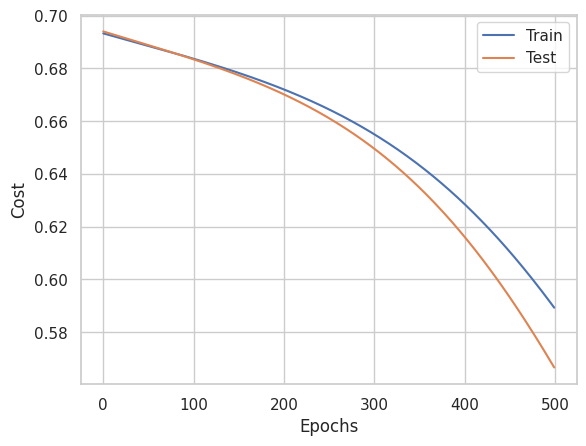

In [12]:
import matplotlib.pyplot as plt
plt.plot(nn1.history["cost"], label="Train")
plt.plot(nn2.history["cost"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.legend()
plt.show()

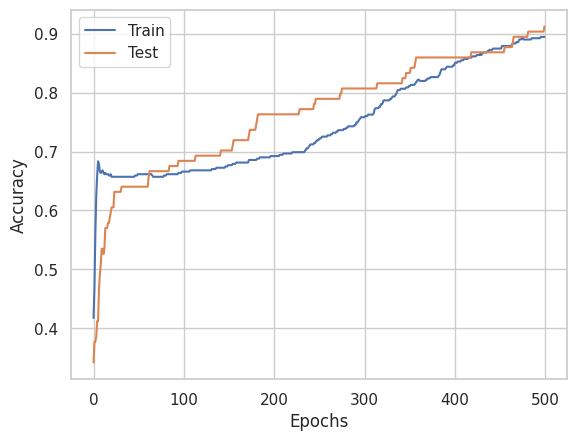

In [13]:
import matplotlib.pyplot as plt
plt.plot(nn1.history["accuracy"], label="Train")
plt.plot(nn2.history["accuracy"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [14]:
# Step 1: Make predictions using the neural network
y_hat = nn1.predict(X_test)

# Step 2: Convert predictions (probabilities) to binary values (0 or 1)
# For binary classification, if the prediction > 0.5, classify as 1 (Malignant), else 0 (Benign)
y_hat = (y_hat > 0.5).astype(int)

y_hat = y_hat[0]
y_true = y_test[0]

# Accuracy
accuracy = accuracy_score(y_true, y_hat)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_hat)
print("Confusion Matrix:")
print(cm)

# Classification Report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_true, y_hat))



Accuracy: 0.8860
Confusion Matrix:
[[30 13]
 [ 0 71]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        43
           1       0.85      1.00      0.92        71

    accuracy                           0.89       114
   macro avg       0.92      0.85      0.87       114
weighted avg       0.90      0.89      0.88       114



In [15]:
class ImprovedNeuralModel(NeuralNetwork):
    def __init__(self):
        super().__init__()
        self.v = {}  # Stores velocity terms for momentum-based optimizers
        self.s = {}  # Stores squared gradients for RMSProp and Adam optimizers
        self.alpha = 0.01  # Default learning rate

    def velocity_initialization(self):
        """
        Initialize velocity and squared gradient terms for optimization algorithms
        """
        for l in range(1, len(self.layers) + 1):
            self.v["dW" + str(l)] = np.zeros(self.params["W" + str(l)].shape)
            self.v["db" + str(l)] = np.zeros(self.params["b" + str(l)].shape)
            self.s["dW" + str(l)] = np.zeros(self.params["W" + str(l)].shape)
            self.s["db" + str(l)] = np.zeros(self.params["b" + str(l)].shape)

    def gradient_descent_with_momentum(self, beta1=0.9, epsilon=1e-8, alpha=0.01):
        """
        Perform gradient descent with momentum (SGD with momentum)
        """
        self.velocity_initialization()
        for l in range(1, len(self.layers) + 1):
            # Update velocities
            self.v["dW" + str(l)] = beta1 * self.v["dW" + str(l)] + (1 - beta1) * self.grads["dW" + str(l)]
            self.v["db" + str(l)] = beta1 * self.v["db" + str(l)] + (1 - beta1) * self.grads["db" + str(l)]

            # Update parameters
            self.params["W" + str(l)] -= alpha * self.v["dW" + str(l)]
            self.params["b" + str(l)] -= alpha * self.v["db" + str(l)]

    def rms_prop(self, beta2=0.999, epsilon=1e-8, alpha=0.01):
        """
        Perform RMSProp optimization
        """
        self.velocity_initialization()
        for l in range(1, len(self.layers) + 1):
            # Update squared gradients
            self.s["dW" + str(l)] = beta2 * self.s["dW" + str(l)] + (1 - beta2) * np.square(self.grads["dW" + str(l)])
            self.s["db" + str(l)] = beta2 * self.s["db" + str(l)] + (1 - beta2) * np.square(self.grads["db" + str(l)])

            # Update parameters with adjusted gradient
            self.params["W" + str(l)] -= alpha * self.grads["dW" + str(l)] / (np.sqrt(self.s["dW" + str(l)]) + epsilon)
            self.params["b" + str(l)] -= alpha * self.grads["db" + str(l)] / (np.sqrt(self.s["db" + str(l)]) + epsilon)

    def adam(self, beta1=0.9, beta2=0.999, epsilon=1e-8, alpha=0.01):
        """
        Perform Adam optimization (combines momentum and RMSProp)
        """
        self.velocity_initialization()
        for l in range(1, len(self.layers) + 1):
            # Update velocities (momentum)
            self.v["dW" + str(l)] = beta1 * self.v["dW" + str(l)] + (1 - beta1) * self.grads["dW" + str(l)]
            self.v["db" + str(l)] = beta1 * self.v["db" + str(l)] + (1 - beta1) * self.grads["db" + str(l)]

            # Update squared gradients (RMSProp)
            self.s["dW" + str(l)] = beta2 * self.s["dW" + str(l)] + (1 - beta2) * np.square(self.grads["dW" + str(l)])
            self.s["db" + str(l)] = beta2 * self.s["db" + str(l)] + (1 - beta2) * np.square(self.grads["db" + str(l)])

            # Correct bias in the estimates (for bias correction in Adam)
            v_corrected = self.v["dW" + str(l)] / (1 - beta1)
            s_corrected = self.s["dW" + str(l)] / (1 - beta2)

            # Update parameters
            self.params["W" + str(l)] -= alpha * v_corrected / (np.sqrt(s_corrected) + epsilon)
            self.params["b" + str(l)] -= alpha * self.v["db" + str(l)] / (np.sqrt(self.s["db" + str(l)]) + epsilon)

    def optimization_selector(self, alpha, optimizer="GD"):
        """
        Select the appropriate optimization method
        """
        if optimizer == "GD":
            self.update_params(alpha)  # Standard gradient descent (no momentum, no adaptive learning rate)
        elif optimizer == "SGD":
            self.gradient_descent_with_momentum(alpha=alpha)  # Stochastic Gradient Descent with momentum
        elif optimizer == "RMSProp":
            self.rms_prop(alpha=alpha)  # RMSProp optimizer
        elif optimizer == "Adam":
            self.adam(alpha=alpha)  # Adam optimizer
        else:
            raise ValueError("Invalid optimizer")

    def fit(self, X, Y, epochs, alpha, optimizer="GD", decay_rate=1):
        """
        Train the neural network using the specified optimizer.
        """
        input_dim = X.shape[0]
        self.initialize_params(input_dim)  # Initialize network parameters

        for i in range(1, epochs + 1):
            # Forward pass: compute activations
            self.forward(X)
            Y_pred = self.params["A" + str(len(self.layers))]  # Output layer activation

            # Calculate cost and accuracy
            cost = self.calculate_cost(Y, Y_pred)
            accuracy = self.accuracy(Y, Y_pred)

            # Print cost and accuracy every 100 epochs
            if i % 100 == 0:
                print(f"Epoch {i}/{epochs}, Cost: {cost:.2f} Accuracy: {accuracy:.2f}")

            # Backward pass: compute gradients
            self.backward(X, Y)

            # Update parameters using selected optimizer
            self.optimization_selector(alpha, optimizer)

    def mini_batch_fit(self, X, Y, epochs, alpha, batch_size, optimizer="GD"):
        """
        Train the neural network using mini-batches and the specified optimizer.
        """
        input_dim = X.shape[0]
        self.initialize_params(input_dim)

        for i in range(1, epochs + 1):
            for j in range(0, X.shape[1], batch_size):
                X_batch = X[:, j:j + batch_size]
                Y_batch = Y[:, j:j + batch_size]

                # Forward pass: compute activations
                self.forward(X_batch)

                # Backward pass: compute gradients
                self.backward(X_batch, Y_batch)

                # Update parameters using selected optimizer
                self.optimization_selector(alpha, optimizer)

                Y_pred = self.params["A" + str(len(self.layers))]

            # Calculate cost and accuracy on mini-batch
            cost = self.calculate_cost(Y_batch, Y_pred)
            accuracy = self.accuracy(Y_batch, Y_pred)

            # Print cost and accuracy every 100 epochs
            if i % 100 == 0:
                print(f"Epoch {i}/{epochs}, Cost: {cost:.4f} Accuracy: {accuracy:.4f}")


In [16]:
nn4 = ImprovedNeuralModel()
nn4.add(64, "tanh")
nn4.add(1, "sigmoid")
nn4.fit(X_train, y_train, epochs=500, alpha=0.01, optimizer = "GD")

Epoch 100/500, Cost: 0.68 Accuracy: 0.69
Epoch 200/500, Cost: 0.67 Accuracy: 0.74
Epoch 300/500, Cost: 0.65 Accuracy: 0.81
Epoch 400/500, Cost: 0.62 Accuracy: 0.88
Epoch 500/500, Cost: 0.57 Accuracy: 0.92


In [24]:
nn5 = ImprovedNeuralModel()
nn5.add(64, "tanh")
nn5.add(1, "sigmoid")
nn5.fit(X_train, y_train, epochs=500, alpha=0.01, optimizer = "SGD")

KeyboardInterrupt: 

In [18]:
nn6 = ImprovedNeuralModel()
nn6.add(64, "tanh")
nn6.add(1, "sigmoid")
nn6.fit(X_train, y_train, epochs=500, alpha=0.01, optimizer = "Adam")

Epoch 100/500, Cost: 0.10 Accuracy: 0.99
Epoch 200/500, Cost: 0.10 Accuracy: 0.98
Epoch 300/500, Cost: 0.07 Accuracy: 0.99
Epoch 400/500, Cost: 0.05 Accuracy: 0.99
Epoch 500/500, Cost: 0.05 Accuracy: 1.00


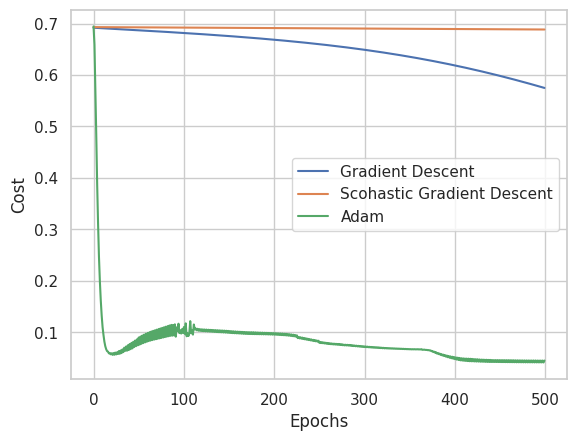

In [20]:
import matplotlib.pyplot as plt
plt.plot(nn4.history["cost"], label="Gradient Descent")
plt.plot(nn5.history["cost"], label="Scohastic Gradient Descent")
plt.plot(nn6.history["cost"], label="Adam")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.legend()
plt.show()

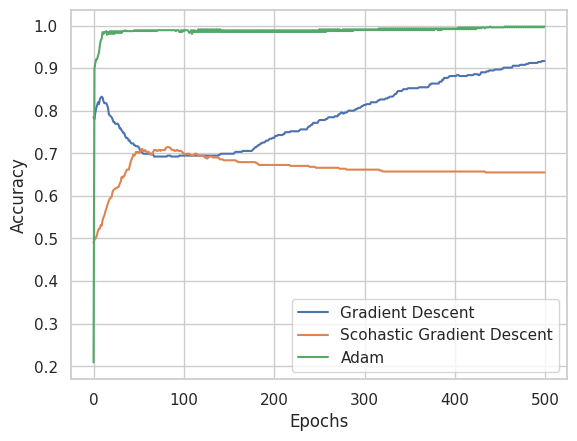

In [21]:
import matplotlib.pyplot as plt
plt.plot(nn4.history["accuracy"], label="Gradient Descent")
plt.plot(nn5.history["accuracy"], label="Scohastic Gradient Descent")
plt.plot(nn6.history["accuracy"], label="Adam")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
nn7 = ImprovedNeuralModel()
nn7.add(64, "tanh")
nn7.add(1, "sigmoid")
nn7.fit(X_test, y_test, epochs=500, alpha=0.01, optimizer = "Adam")